# Преспецификация и недостатъчна спецификация

Да разгледаме проблемът за предсказване на атрибут $y$ на базата на множество от атрибути $x \in R$. Най-лявата графика на фигурата по-долу показва резултата от фитването на данните с линейна хипотеза $y = \theta_0 + \theta_1x$. Вижда се че данните не лежат на права линия и този модел не пасва много добре.

![Overfitting and Underfitting](overfitting.png)

Вместо това ако добавим допълнителен атрибут $X^2$, и използваме хипотеза $y = \theta_0 + \theta_1 x + \theta_2 x^2$, моделът ни пасва по добре към данните, както се вижда на средната графика. На пръв поглед изглежда, че колкото повече атрибути добавяме толкова по-добре, но това също може да бъде опасно. Най-дясната графика показва моделиране на данните с полином от 5-та степен $y = \sum_{j=0} ^5 \theta_j x^j$. При този модел данните са описани перфектно, но от него не очакваме да дава много добри предсказания на да речем цените на апартаменти. 

Първото изображение показва пример на недоспецифициран (underfitting) модел, а най-дясната фигура показва преспецифициран модел (overfitting).
Когато имаме underfitting казваме че моделът има голямо пристрасите (high bias), а когато имаме overfitting казваме още че алогритъмът има голяма свобода (high variance).
Алгоритмите с голямо пристрастие обикновенно се получават в следствие на много прости функции, такива които използват много малък брой параметри, обратното преспецифиция получаваме когато функцията която използваме е много сложна.

Нека да разгледаме отново задачата за класификация на микрочипове. Този път ще използваме библотеката Scikit Learn за да илюстрираме overfitting и underfitting.

In [1]:
# Първо включваме всички библиотеки които ще са ни необходими
%matplotlib inline
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import scipy.optimize as opt  
import os  
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# тази функция визуализира данни кото са в два класа - с етикити 0 или 1
def plot_data(data, accepted, rejected):
    fig, ax = plt.subplots(figsize=(10,8))  
    ax.scatter(np.extract(accepted, data['test1']),np.extract(accepted, data['test2']), c='b', marker='+', label='accepted')
    ax.scatter(np.extract(rejected, data['test1']), np.extract(rejected, data['test2']), c='y', marker='o', label='rejected')
    ax.legend()      
    ax.set_xlabel('Microchips Test 1')  
    ax.set_ylabel('Microchips Test 2') 
    ax.set_aspect('equal', 'datalim')

In [3]:
# зареждаме обучаващите даннит    
data = np.loadtxt('microchips.txt', delimiter=',', dtype={
    'names': ('test1', 'test2', 'score'), 
    'formats': ('f4', 'f4', 'i4')},
)
# нека да видим първите 10 елемента на масива
data[0:10]

array([( 0.051267  ,  0.69955999, 1), (-0.092742  ,  0.68493998, 1),
       (-0.21371   ,  0.69225001, 1), (-0.375     ,  0.50218999, 1),
       (-0.51324999,  0.46564001, 1), (-0.52477002,  0.2098    , 1),
       (-0.39804   ,  0.034357  , 1), (-0.30588001, -0.19225   , 1),
       ( 0.016705  , -0.40424001, 1), ( 0.13191   , -0.51389003, 1)],
      dtype=[('test1', '<f4'), ('test2', '<f4'), ('score', '<i4')])

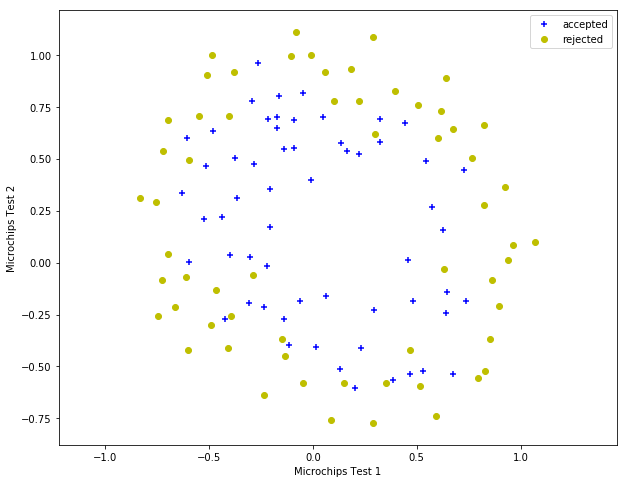

In [4]:
accepted = data['score'] == 1
rejected = data['score'] == 0

# визуализираме данните
plot_data(data, accepted, rejected)
plt.legend();

Един от начините да фитнем данните по-добре е да създадем повече атрибути за всеки пример. Това може да стане като създадем нови полиномиални атрибути от по-висока степен от съществуващите атрибути (данни).
Например можем да създадем допънителни полиноми от втора до шеста степен от същестуващите атрибути x1 и x2. 
$$
{1, x_1, x_2, x_1^2, x_2^2, x_1 x_2, x_2^2, x_1^3, ..., x_2^6}$$

In [6]:
# създаваме полимоми от по-висок ред на атрибутите x1 и x2
def map_features(x1, x2, order=1):
    assert order >= 1
    def iter():
        for i in range(1, order + 1):
            for j in range(i + 1):
                yield np.power(x1, i - j) * np.power(x2, j)
    return np.vstack(iter())

In [7]:
out = map_features(data['test1'], data['test2'], order=6)
X = out.transpose()
Y = data['score']

# параметърът C на LogisticRegression контролира силата на регуларизация
# по малки стойности указват по силна (голяма) регуларизация и респективно, големи стойности по-слаба
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1', C=1)).fit(X, Y)
print 'Accuracy: ', classifier.score(X, Y)

Accuracy:  0.796610169492


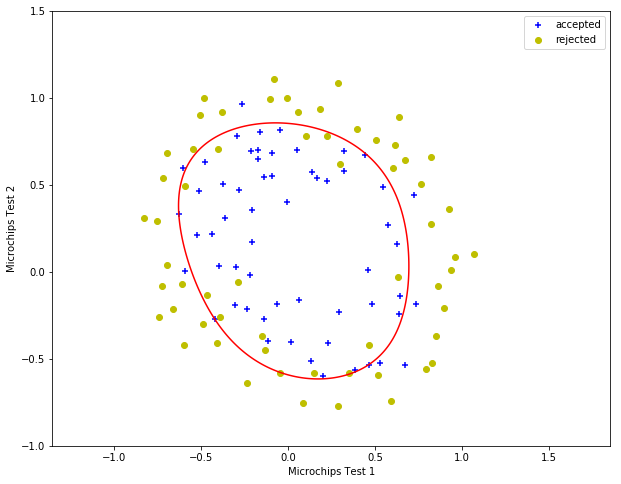

In [8]:
def plot_boundary(classifier):
    dim = np.linspace(-1, 1.5, 1000)
    dx, dy = np.meshgrid(dim, dim)
    v = map_features(dx.flatten(), dy.flatten(), order=6)
    z = (np.dot(classifier.coef_, v) + classifier.intercept_).reshape(1000, 1000)
    CS = plt.contour(dx, dy, z, levels=[0], colors=['r'])

plot_data(data, accepted, rejected)
plot_boundary(classifier)
plt.legend();

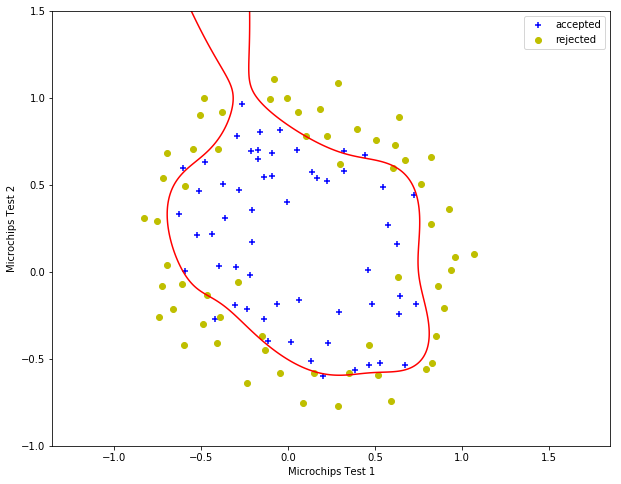

In [9]:
overfitter = OneVsRestClassifier(LogisticRegression(penalty='l1', C=1000)).fit(X, Y)
plot_data(data, accepted, rejected)
plot_boundary(overfitter)
plt.legend();

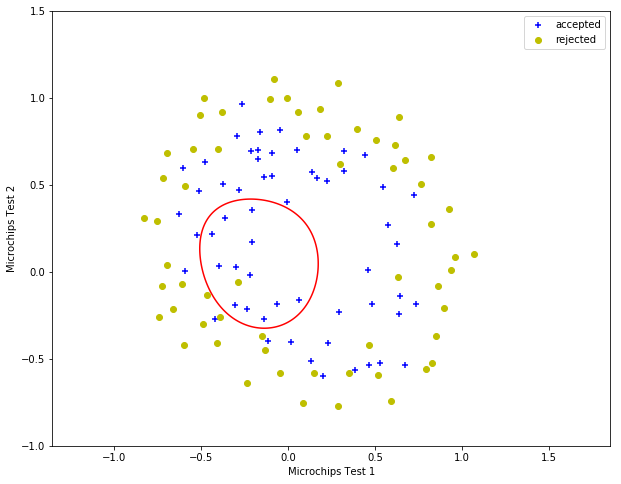

In [10]:
underfitter = OneVsRestClassifier(LogisticRegression(penalty='l2', C=0.01)).fit(X, Y)
plot_data(data, accepted, rejected)
plot_boundary(underfitter)
plt.legend();

# Класификация на множество класове (OneVsAll)

В примерите, които разгледахме до сега решавахме задачата за бинарна класификация. Тоест в данните имаме само два класа - положителни и отрицателни примери. Какво да правим ако искаме да класифицираме повече обекти - например искаме да разпознаваме цифрите от $0$ до $9$. Или искаме да класифицираме автомобили според марката. Формално записано етикета отбелязващ класа на обекта ще има стойносто $y = {0, 1, ..., n}$ при $n$ класа. 

За да решим този проблем разбиваме нашата задача на $n+1$ ($n+1$ защото индексирането ни започва от $0$) задачи за бинарна класификация. За всяка отделна задача предсказваме вероятността примерът, който класифицираме, да е член на един от нащите класове.

$$ y \in \lbrace0, 1 ... n\rbrace$$
$$ h_\theta^{(0)}(x) = P(y = 0 | x ; \theta) $$
$$ h_\theta^{(1)}(x) = P(y = 1 | x ; \theta) $$
$$\cdots$$
$$ h_\theta^{(n)}(x) = P(y = n | x ; \theta) $$
$$\mathrm{prediction} = \max_i( h_\theta ^{(i)}(x) )$$

Ефективно това което правим е да изберем един клас за обекта, който класифицираме и всички останали класове разглеждаме като друг сумарен клас.
Нека да разгледаме 

In [15]:
import scipy.io
data = scipy.io.loadmat('digits.mat');

# избираме случайно 100 цифри
import random
indexes = random.sample(range(0, 5000), 100)

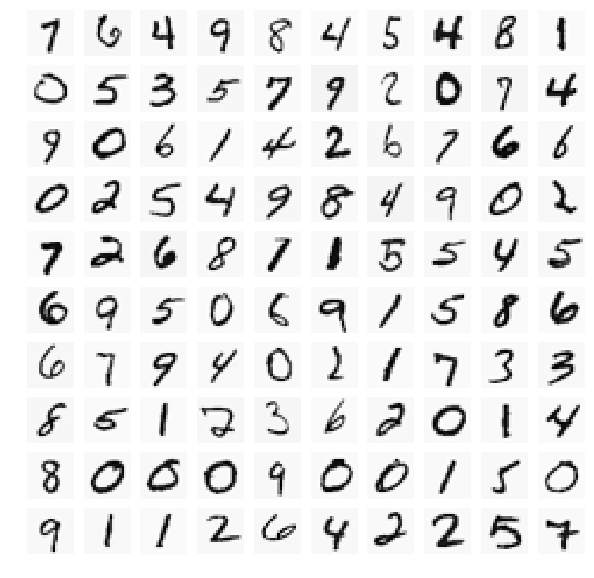

In [16]:
figure = plt.figure(figsize=(10, 10))
for index, i in enumerate(indexes):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(data['X'][i].reshape(20, 20).transpose(), cmap='Greys')

In [17]:
clf = OneVsRestClassifier(LogisticRegression(penalty='l2', C=0.01)
                         ).fit(data['X'], data['y'].ravel())

In [18]:
predicted = clf.predict(data['X'][indexes])
for l, u in zip(range(0, 91, 10), range(10, 101, 10)):
    print map(lambda x: 0 if x == 10 else x, predicted[l:u])
    
print "Predict score for the sample input: %f" % \
    clf.score(data['X'][indexes], data['y'][indexes])

[7, 6, 4, 9, 8, 4, 8, 4, 8, 1]
[0, 5, 3, 5, 7, 9, 1, 0, 7, 4]
[9, 0, 6, 1, 4, 2, 6, 1, 6, 1]
[0, 2, 5, 4, 9, 8, 4, 9, 0, 2]
[7, 2, 6, 8, 1, 1, 8, 5, 4, 5]
[6, 9, 5, 0, 6, 9, 1, 5, 8, 6]
[6, 7, 9, 8, 0, 1, 1, 7, 3, 3]
[8, 4, 1, 7, 5, 6, 2, 0, 1, 4]
[8, 0, 0, 0, 9, 0, 0, 1, 5, 0]
[9, 1, 1, 2, 6, 4, 2, 2, 5, 7]
Predict score for the sample input: 0.900000
